<a href="https://colab.research.google.com/github/DaHyeonnn/poison-mushroom/blob/main/small_data_final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 코랩에서 kaggle dataset 사용하는 방법
[https://soohee410.github.io/colab_kaggle](https://soohee410.github.io/colab_kaggle)

[https://kubig-2021-2.tistory.com/35](https://kubig-2021-2.tistory.com/35)

In [ ]:
# kaggle 설치
!pip install kaggle
from google.colab import files
files.upload() # kaggle.json 업로드

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


TypeError: ignored

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 데이터셋 다운로드
!kaggle datasets download -d harperd17/mushroom-pictures

In [ ]:
# 데이터셋 압축 해제
!unzip mushroom-pictures.zip

In [ ]:
!ls

In [ ]:
# 라이브러리를 한 번에 import
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn # 손실, 활성화 함수, 신경망 생성을 위한 풀링 함수 포함
from torch import optim # optimizer
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from torchvision import transforms
from torchvision import datasets

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import random
import shutil

In [ ]:
import os
from os import path
import glob

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
# pre-trained model 불러오기
# 이미지 분류 문제를 해결할 수 있도록 규모가 큰 데이터로 미리 학습된 모델
model = models.resnet152(pretrained=True)
print(model)

In [ ]:
# 디렉토리리 이름을 변수로 사용할 수 있도록 중간에 있는 공백 '_'가 되도록 디렉토리 이름 수정
%cd /content/All_Mushroom_Data

!mv 'Amanita bisporigera' 'Amanita_bisporigera'
!mv 'Boletus edulis' 'Boletus_edulis'
!mv	'Omphalotus olearius' 'Omphalotus_olearius'
!mv 'Amanita muscaria' 'Amanita_muscaria'
!mv 'Russula mariae' 'Russula_mariae'

%cd ..

In [ ]:
mushrooms = ['Amanita_bisporigera', 'Amanita_muscaria', 'Boletus_edulis', 'Cantharellus', 'Omphalotus_olearius', 'Russula_mariae']
path = '/content/All_Mushroom_Data'

# 각각 디렉토리 내에 있는 파일들을 리스트에 저장
Amanita_bisporigera = glob.glob(path+'/Amanita_bisporigera'+'/*')
Amanita_muscaria = glob.glob(path+'/Amanita_muscaria'+'/*')
Boletus_edulis = glob.glob(path+'/Boletus_edulis'+'/*')
Cantharellus = glob.glob(path+'/Cantharellus'+'/*')
Omphalotus_olearius = glob.glob(path+'/Omphalotus_olearius'+'/*')
Russula_mariae = glob.glob(path+'/Russula_mariae'+'/*')

In [ ]:
# 원본 dataset의 이미지 개수 출력
sum = 0
for elem in mushrooms:
  elem_name = elem
  elem_list = globals()[elem]
  print(f'{elem_name} 이미지 개수: {len(elem_list)}개')
  sum += len(elem_list)
print(f'총 이미지 개수: {sum}')

In [ ]:
# train, valid, test 폴더 생성
!mkdir train
!mkdir valid
!mkdir test

In [ ]:
# train, valid, test 폴더 안에 각각 클래스별 하위 폴더 생성
%cd /content/test
for mushroom in mushrooms:
  os.mkdir(mushroom)

%cd /content/train
for mushroom in mushrooms:
  os.mkdir(mushroom)  

%cd /content/valid
for mushroom in mushrooms:
  os.mkdir(mushroom)

In [ ]:
# 본격적으로 data split을 하기 전에 test, valid 데이터셋에 몇 장이 들어가는지 계산하여 출력

# valid dataset
valid_ratio = 0.2
Amanita_bisporigera_valid_count = round(len(Amanita_bisporigera)*valid_ratio)
Amanita_muscaria_valid_count = round(len(Amanita_muscaria)*valid_ratio)
Boletus_edulis_valid_count = round(len(Boletus_edulis)*valid_ratio)
Cantharellus_valid_count = round(len(Cantharellus)*valid_ratio)
Omphalotus_olearius_valid_count = round(len(Omphalotus_olearius)*valid_ratio)
Russula_mariae_valid_count = round(len(Russula_mariae)*valid_ratio)

for elem in mushrooms:
  print(f'{elem} valid 파일에 들어가는 이미지 개수:', end= ' ')
  print(globals()[elem+'_valid_count'], end=' / ')
  print(len(globals()[elem]))

print('\n')

# test dataset
test_ratio = 0.2
Amanita_bisporigera_test_count = round(len(Amanita_bisporigera)*test_ratio)
Amanita_muscaria_test_count = round(len(Amanita_muscaria)*test_ratio)
Boletus_edulis_test_count = round(len(Boletus_edulis)*test_ratio)
Cantharellus_test_count = round(len(Cantharellus)*test_ratio)
Omphalotus_olearius_test_count = round(len(Omphalotus_olearius)*test_ratio)
Russula_mariae_test_count = round(len(Russula_mariae)*test_ratio)

for elem in mushrooms:
  print(f'{elem} test 파일에 들어가는 이미지 개수:', end= ' ')
  print(globals()[elem+'_test_count'], end=' / ')
  print(len(globals()[elem]))

In [ ]:
# train, valid, test 데이터셋을 나누는 함수
# img_list - 버섯 이미지 파일 리스트
# test_count - test dataset에 들어가는 이미지 개수
# valid_count - valid dataset에 들어가는 이미지 개수
# train_path - train dataset의 경로
# test_path - test dataset의 경로
# valid_path - valid dataset의 경로

def split(img_list, test_count, valid_count, train_path, test_path, valid_path):
  # image shuffle
  np.random.shuffle(img_list)

  test_files=[]
  valid_files=[]

  # test dataset 분리
  for i in random.sample(img_list, test_count):
    test_files.append(i)

  # test dataset에 포함되지 않은 data -> not_test_files (train + valid)
  # not_test_files에서 20%는 valid dataset, 60%는 train dataset으로 분리
  not_test_files = [x for x in img_list if x not in test_files]

  for i in random.sample(not_test_files, valid_count):
    valid_files.append(i)

  train_files = [x for x in not_test_files if x not in valid_files]

  # split한 data들을 train, test, valid 폴더로 복사
  for k in train_files:
    shutil.copy(k, train_path)

  for c in test_files:
    shutil.copy(c, test_path)

  for v in valid_files:
    shutil.copy(v, valid_path)

  print('train 폴더 이미지 개수: {}\nvalid 폴더 이미지 개수: {}\ntest 폴더 이미지 개수: {}\n'.format(len(glob.glob(train_path+'/*')), len(glob.glob(valid_path+'/*')), len(glob.glob(test_path+'/*'))))

In [ ]:
mushrooms = ['Amanita_bisporigera', 'Amanita_muscaria', 'Boletus_edulis', 'Cantharellus', 'Omphalotus_olearius', 'Russula_mariae']

for elem in mushrooms:
  globals()[elem+'_train_path'] = '/content/train/{}'.format(elem)
  globals()[elem+'_valid_path'] = '/content/valid/{}'.format(elem)
  globals()[elem+'_test_path'] = '/content/test/{}'.format(elem)
  split(globals()[elem], globals()[elem+'_test_count'], globals()[elem+'_valid_count'], globals()[elem+'_train_path'], globals()[elem+'_test_path'], globals()[elem+'_valid_path'])

In [ ]:
train_path = '/content/train'
test_path = '/content/test'
valid_path = '/content/valid'

# 이미지 resize
resize_trans = transforms.Compose([transforms.Resize((224, 224)),
                                  transforms.ToTensor(),
                                  ])

resize_train = datasets.ImageFolder(root=train_path, transform=resize_trans)
resize_test = datasets.ImageFolder(root=test_path, transform=resize_trans)
resize_valid = datasets.ImageFolder(root=valid_path, transform=resize_trans)

In [ ]:
# data normaliztion
def get_mean_std(dataset):
  meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
  stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]

  meanR = np.mean([m[0] for m in meanRGB])
  meanG = np.mean([m[1] for m in meanRGB])
  meanB = np.mean([m[2] for m in meanRGB])

  stdR = np.mean([s[0] for s in stdRGB])
  stdG = np.mean([s[1] for s in stdRGB])
  stdB = np.mean([s[2] for s in stdRGB])

  print(meanR, meanG, meanB)
  print(stdR, stdG, stdB)

  mean = [meanR, meanG, meanB]
  std = [stdR, stdG, stdB]

  return mean, std

##아래 normalize 과정에서의 에러 해결 방안##
아래 train, test, valid dataset에 대하여 normalize를 진행할 때, 에러가 발생할 수 있다.
이 때, 에러 메시지를 확인하여 test/valid/train 폴더 중 어느 폴더에서 에러가 났는지 확인한다.
그리고, 아래 Cantharellus에
다운받은 사진(587054.jpg)을 수동으로 추가해준다.  
<아래의 사진 = 587054>
(간혹 아래 사진을 저장할 때, jpeg로 저장될 때가 있는데, 수동 업로드 시 jpg를 업로드해주어야 함을 주의한다.)

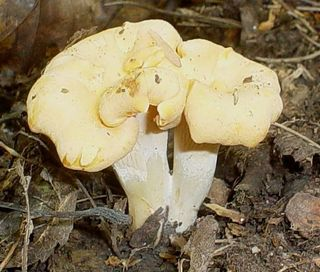

In [ ]:
resize_train_mean, resize_train_std = get_mean_std(resize_train)

In [ ]:
resize_valid_mean, resize_valid_std = get_mean_std(resize_valid)

In [ ]:
resize_test_mean, resize_test_std = get_mean_std(resize_test)

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)), # 이미지 resize
    transforms.ToTensor(),
    transforms.Normalize(resize_train_mean, resize_train_std)
])

transform_valid = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(resize_valid_mean, resize_valid_std)
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(resize_test_mean, resize_test_std)
])

trainset = datasets.ImageFolder(root=train_path, transform=transform_train)
validset = datasets.ImageFolder(root=valid_path, transform=transform_valid)
testset = datasets.ImageFolder(root=test_path, transform=transform_test)

# hyperparameter - batch size를 변경할 수 있는 부분
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=0)

validloader = torch.utils.data.DataLoader(validset, batch_size=256,
                                         shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=True, num_workers=0)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images.shape

In [ ]:
# Freeze network
for param in model.parameters():
    param.requires_grad = False

# 순서를 갖는 모듈의 컨테이너
# 정의된 것과 같은 순서로 모든 모듈들을 통해 전달 -> 신경망을 빠르게 제작
# 참고: https://tutorials.pytorch.kr/beginner/basics/buildmodel_tutorial.html
# nn.Linear(input_dim, output_dim)
# nn.ReLu() - 선형 변환 후에 적용되어 비선형성을 도입
# nn.Dropout() - dropout layer를 추가
# nn.LogSoftmax - 신경망의 마지막 선형 계층을 전달받아 logits을 반환

# 데이터셋의 클래스 개수
num_classes = 6

model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.3),
                                 nn.Linear(512, num_classes),
                                 nn.LogSoftmax(dim=1)
                                )
# loss function
criterion = torch.nn.CrossEntropyLoss()

# 이전에 시도했던 optimizer과 scheduler - 보고서 작성 시 대조군 필요하면 사용 !!

optimizer = optim.Adam(model.fc.parameters(), lr=0.003, weight_decay=0.0)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=3)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
model.to(device) # NeuralNetwork의 인스턴스를 생성하고 이를 device로 이동한 뒤, 구조를 출력

In [ ]:
epochs = 20
steps = 0
running_loss = 0
print_every = 20
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    if(epoch > 4): optimizer.param_groups[0]["lr"] *= 0.9
    print(f'lr: {optimizer.param_groups[0]["lr"]:.5f}')
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in trainloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(trainloader)
        epoch_loss += loss / len(trainloader)

    if steps % print_every == 0:
      with torch.no_grad():

          for data, label in validloader:
              data = data.to(device)
              label = label.to(device)

              val_output = model(data)
              val_loss = criterion(val_output, label)

              acc = (val_output.argmax(dim=1) == label).float().mean()
              epoch_val_accuracy += acc / len(validloader)
              epoch_val_loss += val_loss / len(validloader)
              
      
      print(
          f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
      )
      model.train()

      train_losses.append(epoch_loss)
      val_losses.append(epoch_val_loss)
      train_accs.append(epoch_accuracy)
      val_accs.append(epoch_val_accuracy)
      
    print('\n')

torch.save(model, 'aerialmodel.pth')

In [ ]:
from matplotlib import pyplot as plt
x = [0.0001, 0.003, 0.01]
y = [128, 256]
s = []


In [ ]:
import matplotlib.pyplot as plt

print(train_losses)
print(val_losses)

# 만약 위 print문으로 출력했을 때 원소들이 float가 아니면 아래 두 줄 주석 해제한다.

train_losses = [elem.item() for elem in train_losses]
val_losses = [elem.item() for elem in val_losses]
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
train_accs = [elem.item() for elem in train_accs]
val_accs = [elem.item() for elem in val_accs]
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='val accuracy')
plt.legend(frameon=False)
plt.show()

In [ ]:
test_dir = "/content/test/"
test_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [ ]:
#Test Accuarcy 출력 과정#

accuracy = 0.0
    
with torch.no_grad():
    for data,label in testloader:
        data = data.to(device)
        label = label.to(device)
        outputs = model(data)
        acc = (outputs.argmax(dim=1) == label).float().mean()
        accuracy += acc / len(testloader)

print(f"accuracy: {accuracy:.4f}\n")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('aerialmodel.pth')
model.eval()

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    data = datasets.ImageFolder(test_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:
import PIL
from PIL import Image,ImageDraw,ImageFont
import os
classes = trainloader.dataset.classes
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(20,20))

for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res) + "     ")
    plt.axis('off')
    plt.imshow(image)
    draw =ImageDraw.Draw(image)
    # if (classes[index] == ('Amanita_bisporigera'or 'Amanita_muscaria'or 'Boletus_edulis' or 'Omphalotus_olearius'or 'Russula_mariae')): 
    #   draw.text(str(classes[index]) + ": " + "posion",fill="black",align='bottom' )
    # elif(classes[index] =='Cantharellus'):
    #   draw.text(str(classes[index]) + ": " + "non-posion ",fill="black",align='bottom')
plt.show()

In [ ]:
classes = trainloader.dataset.classes
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    # sub.set_title(str(classes[index]) + ":" + str(res) + "     ")
    plt.axis('off')
    plt.imshow(image)
    if (classes[index] == ('Amanita_bisporigera'or 'Amanita_muscaria'or 'Boletus_edulis' or 'Omphalotus_olearius'or 'Russula_mariae')): 
      sub.set_title(str(classes[index]) + ": " + "posion")
    elif(classes[index] =='Cantharellus'):
      sub.set_title(str(classes[index]) + ": " + "non-posion ")
plt.show()